In [1]:

import torchvision.models as models
import torch.nn as nn
import torch

# Loading a pretrained ResNet-18 model and modifying it for binary classification
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification (2 classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.set_default_dtype(torch.float32)
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# # class Net1(nn.Module):
# #     def __init__(self, num_classes=2):
# #         super(Net1, self).__init__()
# #         input_channels = 3
# #         width_mult = 1.0
# #         self.out_channels = 16
# #         self.features = [nn.Conv2d(input_channels, self.out_channels, kernel_size=3, stride=2, padding=1, bias=False),
# #                          nn.BatchNorm2d(self.out_channels),
# #                          nn.Hardswish(inplace=True)]
# #         #模仿MobileNetV3的网络结构
# #         self.bottlenecks = [
# #             (3, 16, 3, 2),
# #             (3, 24, 3, 2)
# #         ]
# #         for t, c, n, s in self.bottlenecks:
# #             c = int(c * width_mult)
# #             for i in range(n):
# #                 hidden_dim = int(round(self.out_channels * t))
# #                 self.features.append(self._bottleneck(self.out_channels, c, hidden_dim, s if i == 0 else 1))
# #                 self.out_channels = c
# #         self.features = nn.Sequential(*self.features)
# #         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
# #         self.classifier = nn.Sequential(
# #             nn.Linear(c, 96),
# #             nn.Hardswish(inplace=True),
# #             nn.Dropout(0.2),
# #             nn.Linear(96, num_classes),
# #         )
# # 
# #     def forward(self, x):
# #         x = self.features(x)
# #         x = self.avgpool(x)
# #         x = x.view(x.size(0), -1)
# #         x = self.classifier(x)
# #         return x
# # 
# #     def _bottleneck(self, in_channels, out_channels, hidden_dim, stride):
# #         layers = []
# #         if hidden_dim != in_channels:
# #             layers.extend([
# #                 nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
# #                 nn.BatchNorm2d(hidden_dim),
# #                 nn.Hardswish(inplace=True)
# #             ])
# #         layers.extend([
# #             nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
# #             nn.BatchNorm2d(hidden_dim),
# #             nn.Hardswish(inplace=True),
# #             nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
# #             nn.BatchNorm2d(out_channels),
# #         ])
# #         return nn.Sequential(*layers)


In [4]:
# class OptimizedBlock(nn.Module):
#     expansion = 1
#     def __init__(self, in_planes, planes, stride=1):
#         super(OptimizedBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.downsample = None
#         if stride != 1 or in_planes != planes * OptimizedBlock.expansion:
#             self.downsample = nn.Sequential(
#                 nn.Conv2d(in_planes, planes * OptimizedBlock.expansion, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * OptimizedBlock.expansion)
#             )
#     def forward(self, x):
#         residual = x
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         if self.downsample is not None:
#             residual = self.downsample(x)
#         out += residual
#         out = F.relu(out)
#         return out

In [5]:
# # class Net2(nn.Module):
# #     def __init__(self, num_classes=2, block=OptimizedBlock):
# #         super(Net2, self).__init__()
# #         self.in_planes = 64
# #         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# #         self.bn1 = nn.BatchNorm2d(64)
# #         self.relu = nn.ReLU(inplace=True)
# #         self.layer1 = self.res_layer(block, 64, 2, stride=1)
# #         self.layer2 = self.res_layer(block, 128,2, stride=2)
# #         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
# #         self.dropout = nn.Dropout(0.5)
# #         self.fc1 = nn.Linear(128 * block.expansion, 64)
# #         self.fc2 = nn.Linear(64, 32)
# #         self.fc3 = nn.Linear(32, num_classes)
# # 
# #     def res_layer(self, block, planes, num_blocks, stride):
# #         strides = [stride] + [1] * (num_blocks - 1)
# #         layers = []
# #         for stride in strides:
# #             layers.append(block(self.in_planes, planes, stride))
# #             self.in_planes = planes * block.expansion
# #         return nn.Sequential(*layers)
# # 
# #     def forward(self, x):
# #         out = self.conv1(x)
# #         out = self.bn1(out)
# #         out = self.relu(out)
# #         out = self.layer1(out)
# #         out = self.layer2(out)
# #         out = self.avgpool(out)
# #         out = out.view(out.size(0), -1)
# #         out = self.dropout(out)
# #         out = self.fc1(out)
# #         out = F.relu(out)
# #         out = self.dropout(out)
# #         out = self.fc2(out)
# #         out = F.relu(out)
# #         out = self.fc3(out)
# #         return out


In [6]:

import torchvision.models as models
import torch.nn as nn
import torch

model = models.resnet50(pretrained=True)  # 使用预训练的ResNet-50模型
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 修改全连接层以适用于二分类

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 损失函数
def cross_entropy(y_pred, y_true):
    ce_loss = nn.CrossEntropyLoss()(y_pred, y_true)
    return ce_loss

In [8]:
# 正确率评估
def accuracy(predicted, labels):
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    acc = correct / total
    return acc


In [9]:
# 数据加载模块
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = ImageFolder('Digital images of defective and good condition tyres', transform=transform)
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Visual classification ['defective', 'good']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not 

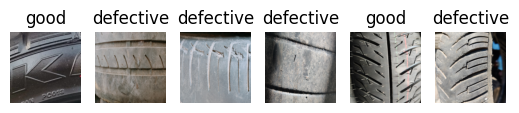

In [10]:
# 可视化分类
classes = dataset.classes
print('Visual classification',classes)
for i, (images, labels) in enumerate(train_loader):
    if i > 0:
        break
    for j in range(len(labels)):
        image = images[j]
        label = labels[j]
        image = image.numpy().transpose((1, 2, 0))
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = image * std + mean
        if j > 0 and j <= 6:
            plt.subplot(1, 6, j)
            plt.imshow(image)
            plt.title(classes[label])
            plt.axis('off')
    plt.savefig('Training visualization')
    plt.show()


In [11]:
## 网络初始化
device = torch.device("cuda:0") # 设置设备
# if torch.cuda.is_avalable():
#     device = torch.device("cuda:0")
# elif torch.backends.mps.is_avalable():
#     device = torch.device("mps")
if device == "cuda:0":
    torch.cuda.set_per_process_memory_fraction(1.0)

In [12]:
# 训练

from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # 优化器
# 定义学习率调度器
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)
# 训练
model.train()
train_losses = []
train_accs = []

val_losses = []
val_accs = []
best_val_acc = 0.0

for epoch in range(20):  # 训练轮数
    train_loss = []
    train_acc = []
    print(f"epoch:{epoch} train start")
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        acc = accuracy(predicted, labels)
        train_acc.append(acc)
        train_loss.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
    print(f"epoch:{epoch} val_start")
    val_loss = []
    val_precision = []
    val_recall = []
    val_acc = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels)
            _, predicted = torch.max(pred, 1)
            acc = accuracy(predicted, labels)
            val_acc.append(acc)
            val_loss.append(loss.cpu().detach().numpy())
    scheduler.step(sum(val_loss) / len(val_loss))
    train_losses.append(sum(train_loss) / len(train_loss))
    train_accs.append(sum(train_acc) / len(train_acc))
    val_losses.append(sum(val_loss) / len(val_loss))
    val_accs.append(sum(val_acc) / len(val_acc))
    val_acc_avg = sum(val_acc) / len(val_acc)
    print("epoch:{},train_acc:{},train_loss:{},val_loss:{} val_acc {}".format(epoch,train_accs[-1] ,train_losses[-1],val_losses[-1], val_accs[-1]))
    if val_acc_avg > best_val_acc:
        # 保存最佳模型
        best_val_acc = val_acc_avg
        torch.save(model.state_dict(), 'model_weights.pth')


epoch:0 train start
epoch:0 val_start
epoch:0,train_acc:0.6690590111642744,train_loss:0.889507769183679,val_loss:0.45651532461245853 val_acc 0.7395833333333334
epoch:1 train start
epoch:1 val_start
epoch:1,train_acc:0.7330542264752792,train_loss:0.5570884577252648,val_loss:0.44272257139285404 val_acc 0.75
epoch:2 train start
epoch:2 val_start
epoch:2,train_acc:0.7763157894736842,train_loss:0.49880758113267887,val_loss:0.4433385406931241 val_acc 0.7708333333333334
epoch:3 train start
epoch:3 val_start
epoch:3,train_acc:0.7529904306220095,train_loss:0.503312651406635,val_loss:0.5688505098223686 val_acc 0.7083333333333334
epoch:4 train start
epoch:4 val_start
epoch:4,train_acc:0.7852870813397129,train_loss:0.46482843955595526,val_loss:0.3937322919567426 val_acc 0.8541666666666666
epoch:5 train start
epoch:5 val_start
epoch:5,train_acc:0.7803030303030304,train_loss:0.4622970969910827,val_loss:0.40058871110280353 val_acc 0.8333333333333334
epoch:6 train start
epoch:6 val_start
epoch:6,train

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

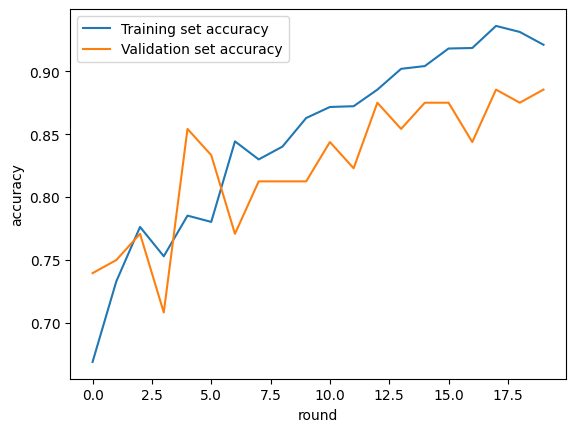

In [13]:
# 正确率 展示
plt.plot(train_accs, label='Training set accuracy')
plt.plot(val_accs, label='Validation set accuracy')
plt.xlabel('round')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Training accuracy')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

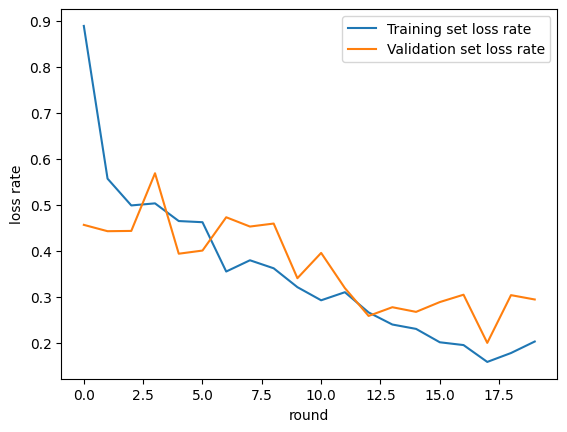

In [14]:
# 损失函数 展示
plt.plot(train_losses, label='Training set loss rate')
plt.plot(val_losses, label='Validation set loss rate')
plt.xlabel('round')
plt.ylabel('loss rate')
plt.legend()
plt.savefig('Training loss rate')
plt.show()

In [15]:
model.load_state_dict(torch.load('model_weights.pth'))#加载模型
model.eval()


y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.cpu().numpy().tolist()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

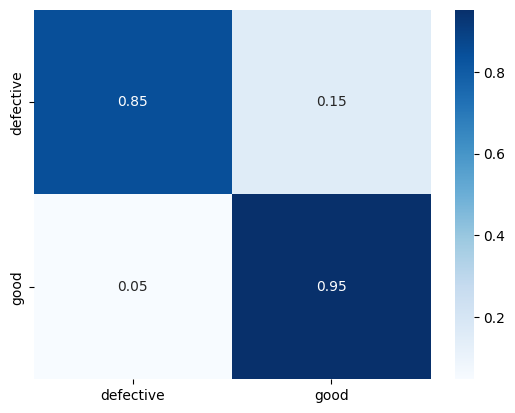

In [16]:
# 绘制混淆矩阵
labels = classes

cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.savefig('Training confusion matrix')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

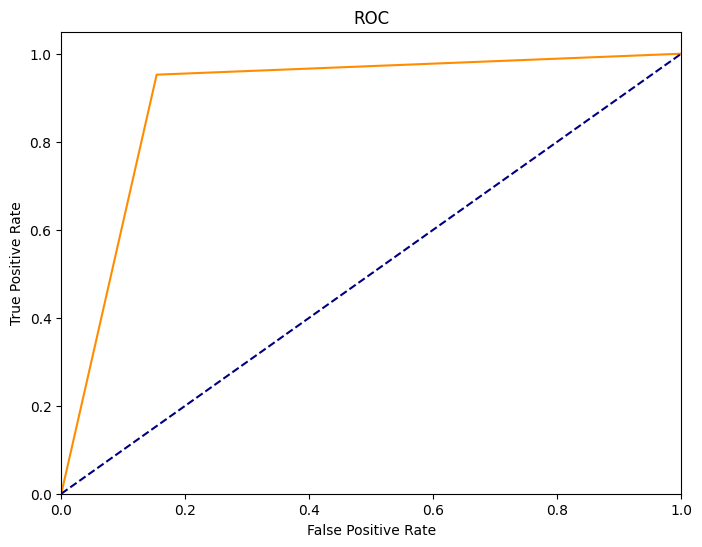

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC ' )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('ROC')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

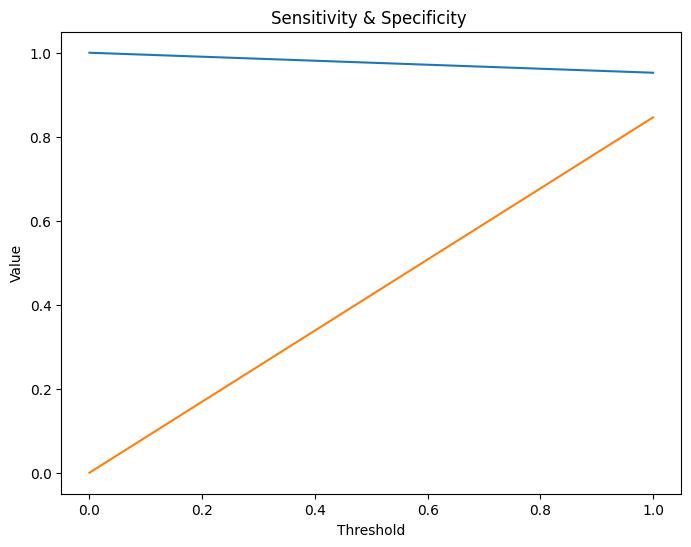

In [18]:
sensitivity = tpr
specificity = 1 - fpr

plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivity, label='Sensitivity')
plt.plot(thresholds, specificity, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Sensitivity & Specificity ')
plt.savefig('Sensitivity & Specificity ')
plt.show()

In [19]:

import torchvision.models as models

# Loading a pretrained ResNet-18 model and modifying it for binary classification
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification (2 classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/environment/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
